# Setup

## Install Detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
# !git clone 'https://github.com/facebookresearch/detectron2'
# dist = distutils.core.run_setup("./detectron2/setup.py")
# !python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
# sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_May__3_19:15:13_PDT_2021
Cuda compilation tools, release 11.3, V11.3.109
Build cuda_11.3.r11.3/compiler.29920130_0
torch:  1.10 ; cuda:  cu113
detectron2: 0.6


## Install Semantic SAM

In [1]:
# !pip3 install torch==1.13.1 torchvision==0.14.1 --extra-index-url https://download.pytorch.org/whl/cu113
# python -m pip install 'git+https://github.com/MaureenZOU/detectron2-xyz.git'
# pip install git+https://github.com/cocodataset/panopticapi.git
!git clone https://github.com/UX-Decoder/Semantic-SAM
# python -m pip install -r requirements.txt

Cloning into 'Semantic-SAM'...
remote: Enumerating objects: 628, done.
remote: Counting objects: 100% (343/343), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 628 (delta 210), reused 267 (delta 160), pack-reused 285
Receiving objects: 100% (628/628), 35.84 MiB | 7.03 MiB/s, done.
Resolving deltas: 100% (267/267), done.


In [5]:
%cd Semantic-SAM

/scratch/shabanza/segmentation/Semantic-SAM


In [9]:
%pip install transformers==4.19.2
%pip install kornia==0.6.4

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 493 kB 5.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Install Mask2Former

In [12]:
# clone and install Mask2Former
# !git clone https://github.com/facebookresearch/Mask2Former.git
%cd ..
%cd Mask2Former
# %pip install git+https://github.com/cocodataset/panopticapi.git
%pip install -r requirements.txt
%cd mask2former/modeling/pixel_decoder/ops
!python setup.py build install

/scratch/shabanza/segmentation
/scratch/shabanza/segmentation/Mask2Former
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
/scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops
running build
running build_py
creating build
creating build/lib.linux-x86_64-3.8
creating build/lib.linux-x86_64-3.8/functions
copying functions/ms_deform_attn_func.py -> build/lib.linux-x86_64-3.8/functions
copying functions/__init__.py -> build/lib.linux-x86_64-3.8/functions
creating build/lib.linux-x86_64-3.8/modules
copying modules/ms_deform_attn.py -> build/lib.linux-x86_64-3.8/modules
copying modules/__init__.py -> build/lib.linux-x86_64-3.8/modules
running build_ext
building 'MultiScaleDeformableAttention' extension
creating /scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops/build/temp.linux-x86_64-3.8
creating /scratch/shabanza/segmentation/Mask2Former

In [13]:
%cd /scratch/shabanza/segmentation/Mask2Former
%cd mask2former/modeling/pixel_decoder/ops
!sudo sh make.sh
%cd /scratch/shabanza/segmentation/Mask2Former

/scratch/shabanza/segmentation/Mask2Former
/scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops
running build
running build_py
running build_ext
building 'MultiScaleDeformableAttention' extension
Emitting ninja build file /scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops/build/temp.linux-x86_64-3.8/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
g++ -pthread -shared -B /opt/conda/compiler_compat -L/opt/conda/lib -Wl,-rpath=/opt/conda/lib -Wl,--no-as-needed -Wl,--sysroot=/ /scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops/build/temp.linux-x86_64-3.8/scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops/src/vision.o /scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops/build/temp.linux-x86_64-3.8/scratch/shabanza/segment

## Imports

In [29]:
%cd ..
%cd Semantic-SAM
from semantic_sam import prepare_image, plot_multi_results, build_semantic_sam, SemanticSAMPredictor, SemanticSamAutomaticMaskGenerator

/scratch/shabanza/segmentation
/scratch/shabanza/segmentation/Semantic-SAM


In [35]:
import random
import cv2
import matplotlib.pyplot as plt

# Dataset

In [ ]:
%cd ..
%cd Mask2Former

In [17]:
from src.dataset.register_comic_instance import *
from detectron2.data import DatasetCatalog, MetadataCatalog

In [18]:
dataset_name = DATASET_NAME

dataset_dicts = DatasetCatalog.get(dataset_name)
metadata = MetadataCatalog.get(dataset_name)

# Model

In [21]:
%cd ..
%cd Semantic-SAM

/scratch/shabanza/segmentation
/scratch/shabanza/segmentation/Semantic-SAM


In [22]:
mask_generator = SemanticSAMPredictor(build_semantic_sam(model_type='L', ckpt='/sinergia/shabanza/checkpoints/semsam/swinl_only_sam_many2many.pth')) # model_type: 'L' / 'T', depends on your checkpint

/opt/conda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
swin_large_patch4_window12_384_22k.pth: 929MB [00:20, 45.8MB/s]                               
$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([2])


# Visualize Samples

In [23]:
sample = random.choice(dataset_dicts)

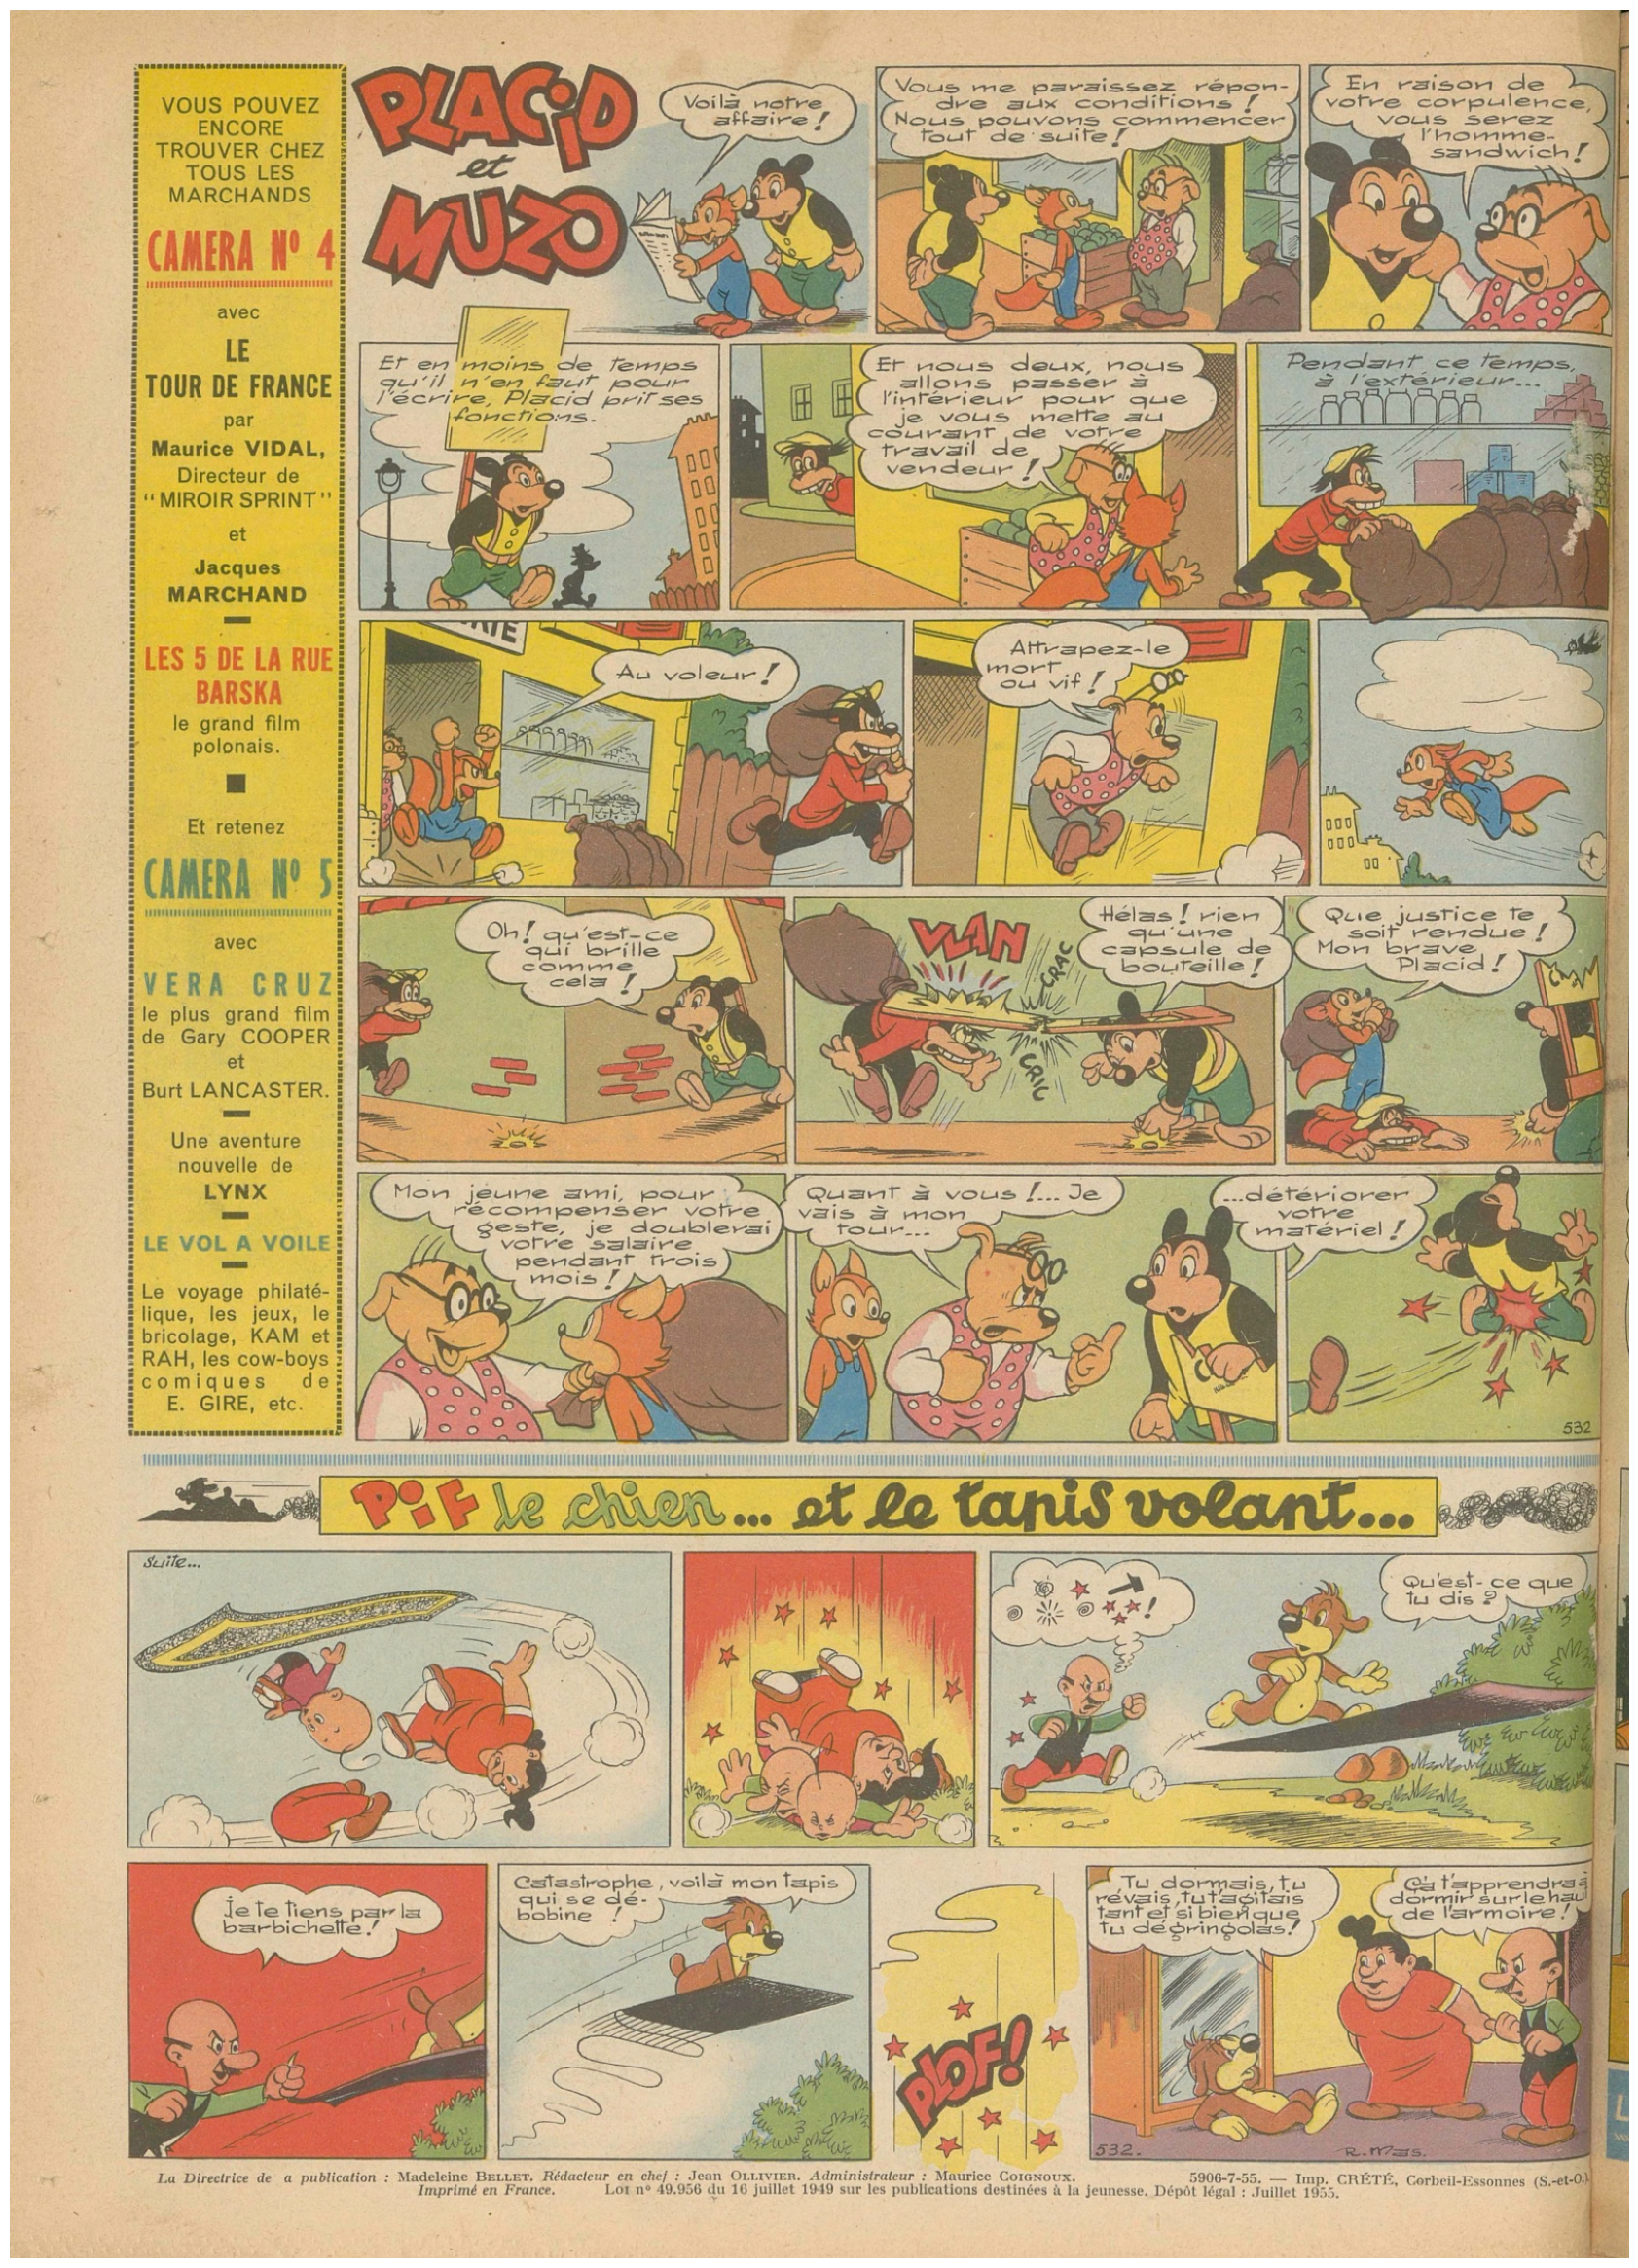

In [38]:
im = cv2.imread(sample['file_name'])[:,:,::-1]
plt.figure(figsize=(30,30))
plt.axis('off')
plt.imshow(im)

In [24]:
original_image, input_image = prepare_image(image_pth=sample['file_name'])  # change the image path to your image

/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [27]:
iou_sort_masks, area_sort_masks = mask_generator.predict_masks(original_image, input_image, point=[[0.5, 0.5]]) # input point [[w, h]] relative location, i.e, [[0.5, 0.5]] is the center of the image
plot_multi_results(iou_sort_masks, area_sort_masks, original_image, save_path='../vis/')  # results and original images will be saved at save_path

/scratch/shabanza/segmentation/Semantic-SAM/semantic_sam/modules/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/scratch/shabanza/segmentation/Semantic-SAM/semantic_sam/body/decoder/utils/utils.py:79: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').

TypeError: interpolate() got an unexpected keyword argument 'antialias'

In [31]:
original_image, input_image = prepare_image(image_pth='examples/dog.jpg')  # change the image path to your image
mask_generator = SemanticSamAutomaticMaskGenerator(build_semantic_sam(model_type='L', ckpt='/sinergia/shabanza/checkpoints/semsam/swinl_only_sam_many2many.pth')) # model_type: 'L' / 'T', depends on your checkpint
masks = mask_generator.generate(input_image)
plot_results(masks, original_image, save_path='../vis/')  # results and original images will be saved at save_path

/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([2])
/scratch/shabanza/segmentation/Semantic-SAM/semantic_sam/modules/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/scratch/shabanza/segmentation/Semantic-SAM/semantic_sam/body/decoder/utils/utils.py:79: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actua

TypeError: interpolate() got an unexpected keyword argument 'antialias'